# Can fingerprint distances discriminate DFG conformations?

The `kissim` fingerprint encodes the pocket residues' spatial distance to four centers&mdash;the pocket centroid, hinge region, DFG region and front pocket&mdash;and should therefore discriminate between two structures in different conformations; when we compare two structures in *different* conformations the fingerprint distance should be higher than for two structures in *similar* conformations.

Let's check if this is true using DFG conformations from KLIFS. Plot distribution of fingerprint distances grouped by in/in, out/out, and in/out pairs.

- Use fingerprint distances for structure pairs between all kinases
- Use fingerprint distances for structure pairs between the same kinase

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from opencadd.databases.klifs import setup_remote
from kissim.comparison import FingerprintDistanceGenerator

from src.definitions import COVERAGE_CUTOFF
from src.paths import PATH_RESULTS

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = PATH_RESULTS / "all"

In [4]:
plt.style.use("seaborn")

## Load fingerprint distances with sufficient coverage

Choose fingerprint distances that are based on spatial distances only (**weighting scheme: 010**) and that are based on a sufficient pairwise fingerprint bit coverage (default: `COVERAGE_CUTOFF`).

In [5]:
COVERAGE_CUTOFF

0.8

In [6]:
# Set path
fingerprint_distance_file = DATA / "fingerprint_distances_010.csv.bz2"
# Load data
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")
structure_distances = fingerprint_distance_generator.data
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances = structure_distances[
    structure_distances["bit_coverage"] >= COVERAGE_CUTOFF
].reset_index(drop=True)
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances.head()

Number of kinases: 279
Number of structures: 4681
Number of structure pairs: 10953540
Number of structure pairs: 10813575


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,1,4,EphA7,EphA7,0.005366,0.96
1,1,8,EphA7,ITK,0.011001,0.94
2,1,9,EphA7,ITK,0.020422,0.96
3,1,11,EphA7,ITK,0.012468,0.96
4,1,12,EphA7,ITK,0.011167,0.94


## Add DFG conformation

Add DFG conformation from KLIFS to each structure pair.

In [7]:
def get_dfg(dfg, structure_klifs_id):
    try:
        return dfg[structure_klifs_id]
    except KeyError:
        return None

In [8]:
%%time
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: get_dfg(dfg, x))
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: get_dfg(dfg, x))
structure_distances.head()

CPU times: user 55 s, sys: 324 ms, total: 55.3 s
Wall time: 57.6 s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2
0,1,4,EphA7,EphA7,0.005366,0.96,out,in
1,1,8,EphA7,ITK,0.011001,0.94,out,in
2,1,9,EphA7,ITK,0.020422,0.96,out,in
3,1,11,EphA7,ITK,0.012468,0.96,out,in
4,1,12,EphA7,ITK,0.011167,0.94,out,in


## Plot DFG conformation pairs

Group the structure pairs by DFG conformation pairs&mdash;in/in, out/out, in/out&mdash;and plot their fingerprint distance distributions.

In [9]:
def structure_distances_by_dfg_conformation_pairs(structure_distances):
    """Distances for all, in/in, out/out, and in/out structure pairs."""

    dfg_in_in = structure_distances[
        (structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "in")
    ]["distance"]
    dfg_out_out = structure_distances[
        (structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "out")
    ]["distance"]
    dfg_in_out = structure_distances[
        ((structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "out"))
        | ((structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "in"))
    ]["distance"]

    structure_distances_dfg = pd.DataFrame(
        {"in/in": dfg_in_in, "out/out": dfg_out_out, "in/out": dfg_in_out}
    )
    structure_distances_dfg = pd.DataFrame(structure_distances_dfg)

    return structure_distances_dfg

In [10]:
def plot_structure_distances_by_dfg_conformation_pairs(structure_distances, kinase):
    """Plot distribution of structure distances per DFG conformation pair."""

    # Data
    structure_distances_dfg = structure_distances_by_dfg_conformation_pairs(structure_distances)
    print("Number of structure pairs per conformation pair:")
    print(structure_distances_dfg.notna().sum())

    # Boxplot
    fig, ax = plt.subplots(1, 1, figsize=(3.33, 3.33))
    structure_distances_dfg.plot(kind="box", ax=ax)
    ax.set_xlabel(
        "Type of DFG conformation pairs"
        if kinase is None
        else f"Type of DFG conformation pairs ({kinase})"
    )
    ax.set_ylabel("Fingerprint distances (spatial features only)")
    if kinase is None:
        fig.savefig(
            HERE / "../figures/kissim_discriminates_dfg.png",
            dpi=300,
            bbox_inches="tight",
        )
    else:
        fig.savefig(
            HERE / f"../figures/kissim_discriminates_dfg_{kinase}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

    # Stats
    display(structure_distances_dfg.describe())

### All structures

Use fingerprint distances for structure pairs between all kinases.

Number of structure pairs per conformation pair:
in/in      8280415
out/out      76636
in/out     1595440
dtype: int64


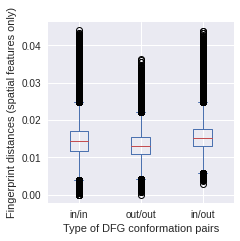

,in/in,out/out,in/out
count,8.280415e+06,76636.000000,1.595440e+06
mean,1.491358e-02,0.013598,1.582709e-02
std,4.937937e-03,0.004601,4.278712e-03
min,0.000000e+00,0.000000,2.914814e-03
25%,1.177078e-02,0.010945,1.295652e-02
50%,1.431896e-02,0.012927,1.509459e-02
75%,1.698472e-02,0.015457,1.770736e-02
max,4.412086e-02,0.036295,4.379422e-02


In [11]:
plot_structure_distances_by_dfg_conformation_pairs(structure_distances, kinase=None)

<div class="alert alert-block alert-info">

When including all kinases at the same time, the distribution of fingerprint distances is similar for structure pairs with the same DFG conformations (in/in and out/out) and different DFG conformations (in/out). 
    
The fingerprint seems not to discriminate DFG-conformations on a kinome-wide level, maybe because the encoded spatial information is not restricted to only DFG conformation features. We may see a disciminative effect when comparing structures for a single kinase.

</div>

### Structures for one kinase

Use fingerprint distances for structure pairs between the same kinase; use only kinases that have a sufficient number of structures in DFG-in and DFG-out conformations (default: 10). 

In [12]:
def kinases_with_high_dfg_in_out_coverage(structure_distances, dfg_structure_coverage_cutoff=10):
    """Given a dataset, get kinases with a threshold DFG in/out coverage."""

    # Get structure KLIFS IDs in our dataset
    structure_klifs_ids = (
        pd.concat(
            [
                structure_distances["structure.1"].drop_duplicates(),
                structure_distances["structure.2"].drop_duplicates(),
            ]
        )
        .drop_duplicates()
        .to_list()
    )
    print(f"Number of structures: {len(structure_klifs_ids)}")

    # Get structural metadata
    klifs_session = setup_remote()
    structures = klifs_session.structures.all_structures()
    structures = structures[structures["structure.klifs_id"].isin(structure_klifs_ids)]

    # Count number of structures per kinase and conformation
    dfg_by_kinase = structures.groupby("kinase.klifs_name").apply(
        lambda x: x["structure.dfg"].value_counts()
    )
    dfg_by_kinase = dfg_by_kinase.reset_index()
    dfg_by_kinase.columns = ["kinase", "dfg", "n_structures"]

    # Keep only in/out rows
    dfg_by_kinase = dfg_by_kinase[(dfg_by_kinase["dfg"] == "in") | (dfg_by_kinase["dfg"] == "out")]

    # Keep only rows with at least xxx structures
    dfg_by_kinase = dfg_by_kinase[dfg_by_kinase["n_structures"] >= dfg_structure_coverage_cutoff]

    # Keep only kinases with both in/out conformations
    n_conformations_by_kinase = dfg_by_kinase.groupby("kinase").size()
    dfg_by_kinase = dfg_by_kinase[
        dfg_by_kinase["kinase"].isin(
            n_conformations_by_kinase[n_conformations_by_kinase == 2].index
        )
    ]

    return dfg_by_kinase.set_index(["kinase", "dfg"])

In [13]:
dfg_by_kinase = kinases_with_high_dfg_in_out_coverage(
    structure_distances, dfg_structure_coverage_cutoff=10
)
dfg_by_kinase

Number of structures: 4651


n_structures
kinase dfg              
BRAF   in             28
       out            21
CDK8   in             21
       out            10
EphA2  in             37
       out            17
MET    in             54
       out            16
p38a   in            111
       out            57

#### BRAF

Number of DFG-in structures: 28
Number of DFG-out structures: 21
Percentage of DFG-in: 57.14%
Number of structure pairs per conformation pair:
in/in      378
out/out    210
in/out     588
dtype: int64


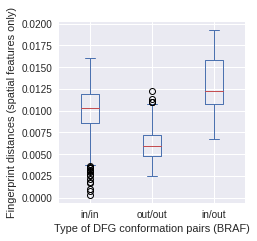

,in/in,out/out,in/out
count,378.000000,210.000000,588.000000
mean,0.009999,0.006218,0.012907
std,0.003259,0.001905,0.002980
min,0.000347,0.002455,0.006698
25%,0.008616,0.004774,0.010791
50%,0.010338,0.005933,0.012247
75%,0.011901,0.007228,0.015821
max,0.016073,0.012190,0.019253


#### CDK8

Number of DFG-in structures: 21
Number of DFG-out structures: 10
Percentage of DFG-in: 67.74%
Number of structure pairs per conformation pair:
in/in      210
out/out     45
in/out     210
dtype: int64


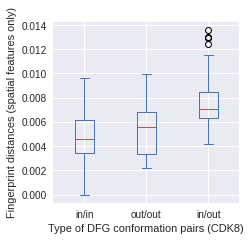

,in/in,out/out,in/out
count,210.000000,45.000000,210.000000
mean,0.004781,0.005532,0.007500
std,0.001739,0.002250,0.001760
min,0.000000,0.002217,0.004208
25%,0.003392,0.003391,0.006361
50%,0.004583,0.005561,0.007087
75%,0.006199,0.006790,0.008485
max,0.009640,0.009982,0.013590


#### EphA2

Number of DFG-in structures: 37
Number of DFG-out structures: 17
Percentage of DFG-in: 68.52%
Number of structure pairs per conformation pair:
in/in      666
out/out    136
in/out     629
dtype: int64


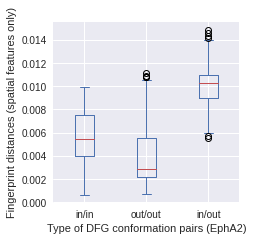

,in/in,out/out,in/out
count,666.000000,136.000000,629.000000
mean,0.005362,0.004467,0.010040
std,0.002345,0.003170,0.001626
min,0.000660,0.000736,0.005539
25%,0.003956,0.002208,0.008977
50%,0.005436,0.002841,0.010301
75%,0.007538,0.005561,0.011012
max,0.009976,0.011123,0.014855


#### MET

Number of DFG-in structures: 54
Number of DFG-out structures: 16
Percentage of DFG-in: 77.14%
Number of structure pairs per conformation pair:
in/in      1431
out/out     120
in/out      864
dtype: int64


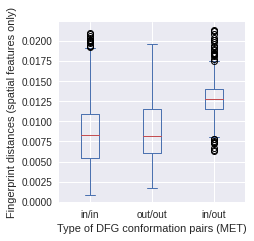

,in/in,out/out,in/out
count,1431.000000,120.000000,864.000000
mean,0.008581,0.009054,0.012868
std,0.004076,0.004335,0.002186
min,0.000899,0.001665,0.006291
25%,0.005475,0.006060,0.011576
50%,0.008242,0.008124,0.012819
75%,0.010943,0.011581,0.013961
max,0.020947,0.019615,0.021350


#### p38a

Number of DFG-in structures: 111
Number of DFG-out structures: 57
Percentage of DFG-in: 66.07%
Number of structure pairs per conformation pair:
in/in      6105
out/out    1596
in/out     6327
dtype: int64


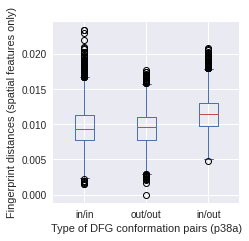

,in/in,out/out,in/out
count,6105.000000,1596.000000,6327.000000
mean,0.009641,0.009372,0.011539
std,0.002897,0.002908,0.002354
min,0.001453,0.000000,0.004750
25%,0.007714,0.007770,0.009821
50%,0.009383,0.009552,0.011480
75%,0.011324,0.010993,0.013046
max,0.023417,0.017729,0.020856


In [14]:
for kinase, dfg in dfg_by_kinase.reset_index().groupby("kinase"):
    display(Markdown(f"#### {kinase}"))
    dfg = dfg.set_index("dfg")
    n_dfg_in = dfg.loc["in", "n_structures"]
    n_dfg_out = dfg.loc["out", "n_structures"]
    print(f"Number of DFG-in structures: {n_dfg_in}")
    print(f"Number of DFG-out structures: {n_dfg_out}")
    dfg_in_percentage = round(n_dfg_in / (n_dfg_in + n_dfg_out) * 100, 2)
    print(f"Percentage of DFG-in: {dfg_in_percentage}%")
    structure_distances_by_kinase = structure_distances[
        (structure_distances["kinase.1"] == kinase) & (structure_distances["kinase.2"] == kinase)
    ].reset_index(drop=True)
    plot_structure_distances_by_dfg_conformation_pairs(structure_distances_by_kinase, kinase)

<div class="alert alert-block alert-info">

We compare here only fingerprint distances for pairs of structures that describe the same kinase. We observe two interesting shifts:
    
1. The distribution for out/out pairs is overall lower than for in/in pairs. Potential explanations: definitions for DFG-out are stricter than for DFG-in; "real" diversity of DFG-out structures could be still unknown due to the lower number of structures for DFG-out than for DFG-in. 
2. The distribution of different DFG conformations (in/out) is overall higher than for equal DFG conformations (in/in and out/out). The fingerprint can discriminate DFG conformations of the same kinase.

</div>